# Virtual Pruning

## Importing the digitized structure

In [44]:
from openalea.mtg import *
import numpy as np
from importlib import reload
import mangoG3; reload(mangoG3)
from mangoG3 import *

g = get_G3_mtg()

In [45]:
from matplotlib.pyplot import *
import mtgplot as mp
reload(mp)

<module 'mtgplot' from '/Users/fboudon/Develop/oagit/virtualpruning/notebooks/mtgplot.py'>

In [3]:
#sw = mp.plot_tree(g, leaves=True)
#sw


# Pruning

In [46]:
import pruning ; reload(pruning)
from pruning import *

In [47]:
prunedmtg = prune(g, 180)

In [48]:
intensity = continuous_intensity_from_pruned(prunedmtg)
print(intensity, intensity_level(intensity))

0.0 T0


In [75]:
from regrowth import *

In [ ]:
regrowth, newids = growth(postpruningmtg, intensity)

# Drone simulation

In [50]:
repr = mp.representation(g, wood = True, leaves=True, sensors=False)


In [85]:
import drone ; reload(drone)
from drone import *

In [59]:
points, colors = dronescan(repr)


In [9]:
mp.display(Scene([Shape(Translated(p,Sphere(1)),Material(c)) for p,c in zip(points,colors)]))
#mp.display(Scene([Shape(Translated(p,Sphere(1))) for p in points]))

SceneWidget(scenes=[{'id': 'VxOKumuFGP7FAzHqMBhDO7PXX', 'data': b'x\xda\x8c\x9d\x07t\\\xd5\xb5\xfee\x8a\x01c\x…

In [97]:
initvolume = volume_estimate(points)

# Large simulations

In [78]:
from mortality import gu_mortalities_post_pruning
from lightestimation import *

In [92]:
def volume_simulation(nbcuts):
    prunedmtg = prune(g, nbcuts)
    intensity = continuous_intensity_from_pruned(prunedmtg)
    postpruningmtg, removed = gu_mortalities_post_pruning(prunedmtg, intensity)
    prunedrepr = mp.representation(postpruningmtg, wood = False, leaves=True)
    Zeta_mean = light_variables(prunedrepr, skydiscretization=16)
    redo = True
    test = 0
    while redo == True and test <= 5:
        print('Test', test)
        redo = False
        try:
            regrowth, newids = growth(postpruningmtg, intensity, Zeta_mean=Zeta_mean)
        except Exception as e:
            if test  == 5 : raise e
            redo = True
            test += 1
    
    repr = mp.representation(prunedmtg, wood = True, leaves=True, sensors=False)
    points, colors = dronescan(repr)
    volpruned = volume_estimate(points)
    
    repr = mp.representation(regrowth, wood = True, leaves=True, sensors=False)
    points, colors = dronescan(repr)
    volregrowth = volume_estimate(points)
    return i, intensity, volpruned, volregrowth, Zeta_mean
    

In [93]:
result = []
for i in range(0,181,45):
    print(i)
    result.append(volume_simulation(int(i)))

0
Should examine 3228  GUs.
Test 0
Should examine 3038 terminal GUs (190 deads).
Processed 0 pruned terminal GU and 3001 unpruned terminal GU and  37 ignored.
45
Should examine 3052  GUs.
Test 0
Should examine 2865 terminal GUs (187 deads).
Processed 111 pruned terminal GU and 2716 unpruned terminal GU and  38 ignored.
90
Should examine 2806  GUs.
Test 0
Should examine 2595 terminal GUs (211 deads).
4.699999999999999 0.2766943417406788 0
Test 1
Should examine 2595 terminal GUs (211 deads).
Processed 208 pruned terminal GU and 2351 unpruned terminal GU and  36 ignored.
135
Should examine 2621  GUs.
Test 0
Should examine 2391 terminal GUs (230 deads).
Processed 306 pruned terminal GU and 2053 unpruned terminal GU and  32 ignored.
180
Should examine 2447  GUs.
Test 0
Should examine 2190 terminal GUs (257 deads).
Processed 385 pruned terminal GU and 1775 unpruned terminal GU and  30 ignored.


In [98]:
simvolumes = DataFrame({'before pruning' : dict([(i,initvolume) for i, inty, vp, vr, z in result]), 
                     'after pruning' : dict([(i,vp) for i, inty, vp, vr, z in result]), 
                     'after regrowth' : dict([(i,vr) for i, inty, vp, vr, z in result]), 
                     'intensity' : dict([(i,inty) for i, inty, vp, vr, z in result])})
print(simvolumes)

     before pruning  after pruning  after regrowth  intensity
0         42.567711      42.567711       43.165584   0.000000
45        42.567711      41.610437       43.239829   0.138794
90        42.567711      40.716342       43.464940   0.276694
135       42.567711      38.937765       43.594349   0.424096
180       42.567711      38.211867       44.225511   0.568258


# Analysis

In [2]:
trees = ['H15','F7','E11','C14','D8','G15','F8','H16','D7','F11','B12','C13','C16']
intensities = [0,0,0,0,0.10,0.13,0.17,0.20,0.32,0.46,0.48,0.51,0.55]

In [5]:
from pandas import *

In [6]:
volumes_bef = {}
volumes_aft = {}
volumes_end = {}

for name in trees:
    volumes_bef[name] = volume(fname0 % name)
    volumes_aft[name] = volume(fname1 % name)
    volumes_end[name] = volume(fname2 % name)


     before pruning  after pruning  after growth
H15       81.395497      75.567917     84.499266
F7        92.738787      99.157655     95.219853
E11       91.809142      93.386117     93.234193
C14       87.048376      88.057226     92.421049
D8       113.367551     111.524826    110.478751
G15       91.470348      79.874876     90.852184
F8        88.396981      84.694642     83.250164
H16       74.486569      69.069826     76.137961
D7        81.864552      72.736921     78.792123
F11      102.280309      83.586057    100.398136
B12       97.286556      82.316266     89.685102
C13       85.480341      73.291038     85.601281
C16       86.250348      73.761655     85.180079


In [9]:
volumes = DataFrame({'before pruning' : volumes_bef, 'after pruning' : volumes_aft, 'after regrowth' : volumes_end})
print(volumes)

     before pruning  after pruning  after regrowth
H15       81.395497      75.567917       84.499266
F7        92.738787      99.157655       95.219853
E11       91.809142      93.386117       93.234193
C14       87.048376      88.057226       92.421049
D8       113.367551     111.524826      110.478751
G15       91.470348      79.874876       90.852184
F8        88.396981      84.694642       83.250164
H16       74.486569      69.069826       76.137961
D7        81.864552      72.736921       78.792123
F11      102.280309      83.586057      100.398136
B12       97.286556      82.316266       89.685102
C13       85.480341      73.291038       85.601281
C16       86.250348      73.761655       85.180079


In [10]:
from matplotlib.pyplot import *

<AxesSubplot:>

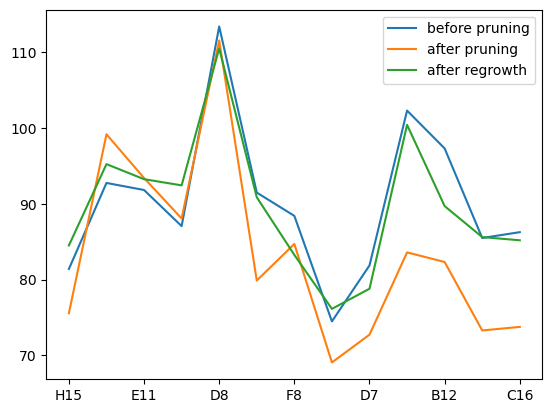

In [11]:
volumes.plot()

In [99]:
def estimate_dvolumes(volumes):
    return DataFrame({'after pruning' : (volumes['after pruning']-volumes['before pruning'])*100/volumes['before pruning'],
                          'after regrowth' : (volumes['after regrowth']-volumes['after pruning'])*100/volumes['before pruning'], 
                         'after pruning and regrowth' : (volumes['after regrowth']-volumes['before pruning'])*100/volumes['before pruning']
                         })

<AxesSubplot:>

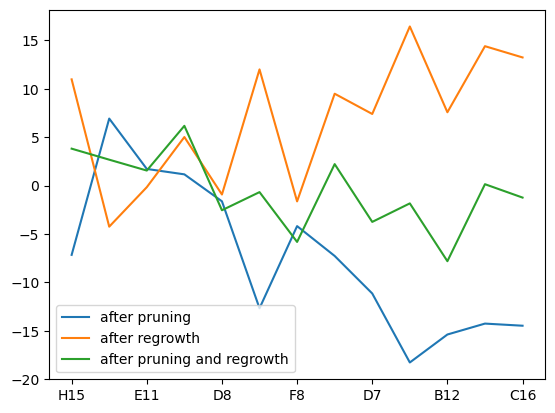

In [100]:
deltavolumes = estimate_dvolumes(volumes)
deltavolumes.plot()

In [101]:
def plot_deltavolumes(deltavolumes, intensities):
    def plotset(label):
        z = np.polyfit(intensities, deltavolumes[label], 1)
        p = np.poly1d(z)
        cv = [min(intensities)-0.1,max(intensities)+0.1]

        sc = scatter(intensities, deltavolumes[label], label = label+' : I x '+str(round(z[0],2))+'%')
        plot(cv, list(map(p,cv)), "-", color=sc.get_edgecolor())

    hlines(0, min(intensities)-0.1,max(intensities)+0.1,colors=['black'])
    plotset('after pruning')
    plotset('after regrowth')
    plotset('after pruning and regrowth')
    xlim(-0.05, 0.6)
    legend()

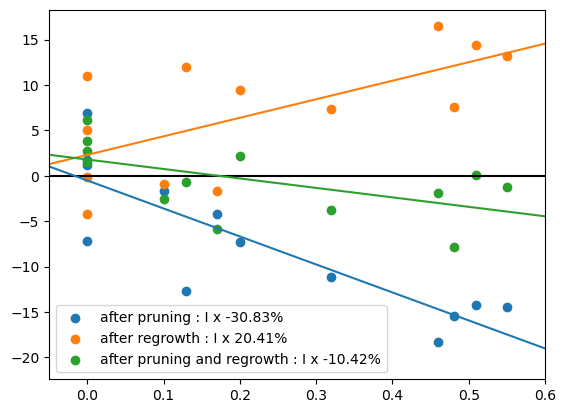

In [102]:
plot_deltavolumes(deltavolumes, intensities)

In [103]:
deltasimvolumes = estimate_dvolumes(simvolumes)

<AxesSubplot:>

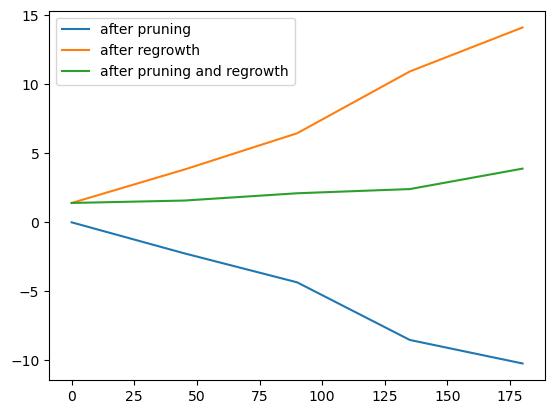

In [105]:
deltasimvolumes.plot()

0       0.000000
45     -2.248826
90     -4.349233
135    -8.527463
180   -10.232741
Name: after pruning, dtype: float64
5


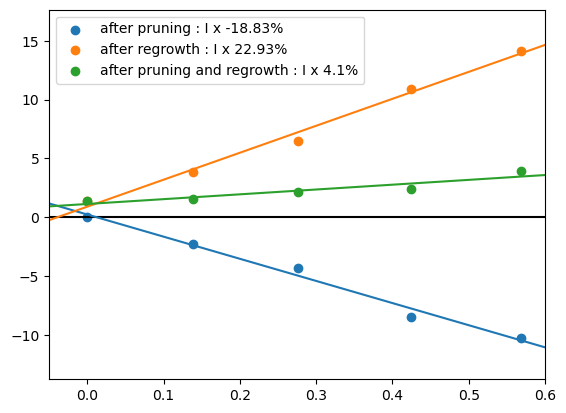

In [109]:
print(deltasimvolumes['after pruning'])
print(len(simvolumes['intensity']))

plot_deltavolumes(deltasimvolumes, simvolumes['intensity'])

In [116]:
def myhist(ax, values, bins=10):
    import numpy as np
    from scipy.interpolate import interp1d
    hist, bin_edges = np.histogram(values, density=True,bins=bins)
    histx = [bin_edges[0]]+[(bin_edges[i]+bin_edges[i+1])/2 for i in range(len(hist))]+[bin_edges[-1]]
    histy = [hist[0]]+list(hist)+[hist[-1]]
    cubic_interpolation_model = interp1d(histx, histy, kind = "cubic")
    X_=np.linspace(min(histx),max(histx), 500)
    Y_=cubic_interpolation_model(X_)
    ax.plot(X_,Y_)
    verts = [(histx[0], 0), *zip(X_, Y_), (histx[-1], 0)]
    poly = Polygon(verts, facecolor='0.9', edgecolor='0.5')
    ax.add_patch(poly)


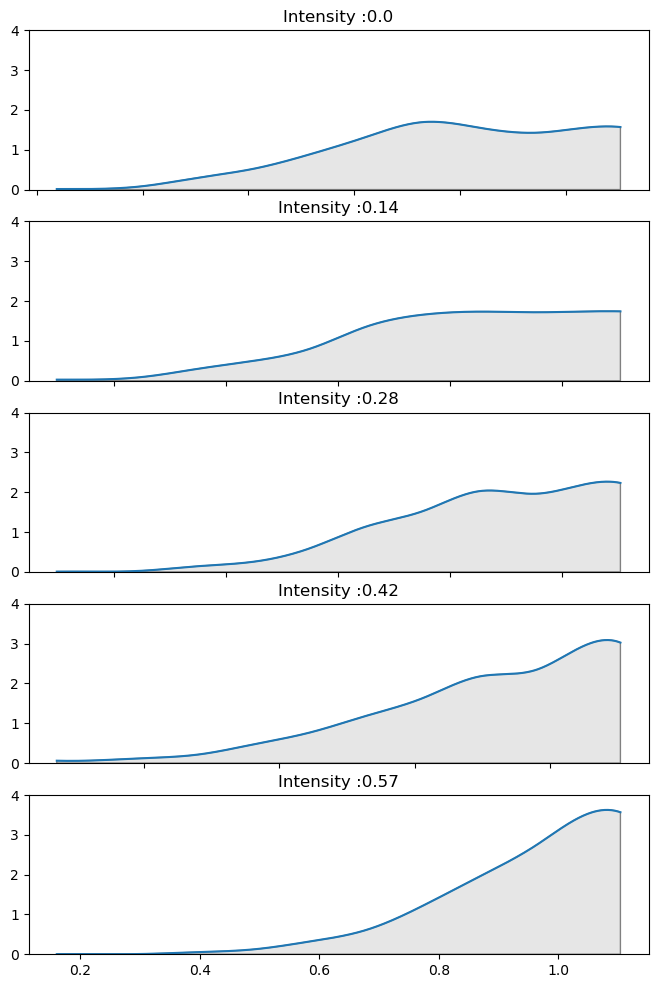

In [122]:
fig, ax = subplots(5, figsize=(8,12))
for i in range(5):
    myhist(ax[i], result[i][4])
    ax[i].set_ylim((0,4))
    ax[i].set_title('Intensity :'+str(round(result[i][1],2)))
    if i != 4:
        ax[i].set_xticklabels([])
show()